In [1]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h

import torch
from torch import nn, optim, Tensor
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes
from torchvision.ops.roi_pool import RoIPool
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import box_iou

import cv2
import numpy as np

from typing import Optional

In [2]:
transforms = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(min_size=15.0),
    v2.Resize((224, 224)),
    v2.SanitizeBoundingBoxes(min_size=15.0),
    v2.ToDtype(torch.float32)
])

In [3]:
train_dataset, val_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms
val_dataset.transform = transforms

./data_object_image_2/training/image_2/


In [4]:
n_classes = len(class_names)

<class 'list'>
[tensor([[[ 15.,  27.,  13.,  ..., 255., 248., 250.],
         [  8.,   8.,   8.,  ..., 198., 183., 245.],
         [  6.,  10.,   8.,  ..., 164.,  69., 168.],
         ...,
         [145., 153., 162.,  ..., 138., 139., 130.],
         [172., 171., 179.,  ..., 149., 153., 152.],
         [165., 163., 159.,  ..., 141., 147., 149.]],

        [[ 15.,  23.,  23.,  ..., 255., 255., 255.],
         [ 13.,  13.,  12.,  ..., 247., 218., 246.],
         [ 12.,  12.,  12.,  ..., 218., 119., 185.],
         ...,
         [165., 164., 166.,  ..., 135., 143., 144.],
         [163., 174., 174.,  ..., 146., 151., 147.],
         [149., 161., 160.,  ..., 152., 157., 154.]],

        [[ 10.,  16.,  18.,  ..., 255., 255., 255.],
         [  9.,   9.,  10.,  ..., 249., 209., 251.],
         [ 10.,   9.,   8.,  ..., 237., 100., 210.],
         ...,
         [162., 171., 164.,  ..., 127., 123., 145.],
         [169., 176., 166.,  ..., 138., 155., 156.],
         [144., 154., 162.,  ..., 153

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


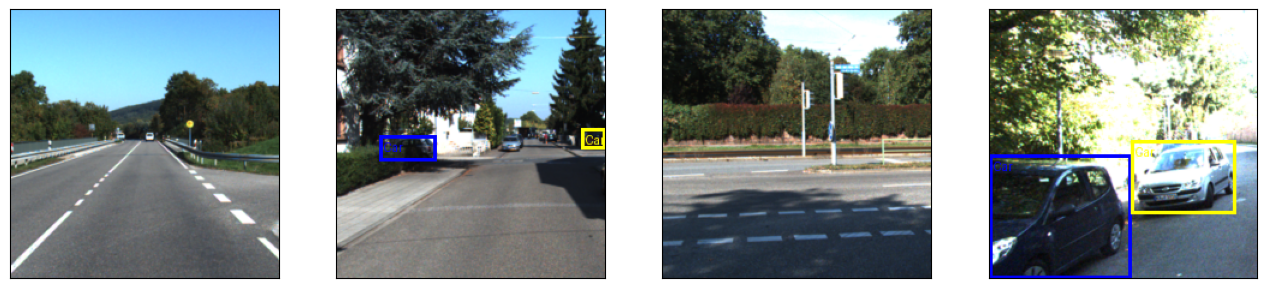

In [5]:
data_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
elements = next(iter(data_loader))
print(type(elements))
print(elements)
for element in elements:
    print(type(element))
    print(element)
display_samples_h([next(iter(data_loader)) for _ in range(4)])

**VGG16**
<br>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*0M8CobXpNwFDCmOQ">

In [6]:
def new_forward(model, x):
        x = model.features(x)
        # Skipping the flattening, the average pooling and the original classifier
        return x

In [7]:
class FastRCNN(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.dropout=0.5
                
        self.conv = self._prepare_vgg16()
        print(self.conv)
        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=0.0625) # Input: 224 * 224 | roi input: 14 * 14 -> 14/224 = 0.0625
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),   # Is it 512? Not 64?
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
            nn.Linear(in_features=4096, out_features=4096),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=n_classes + 1),
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4),
        )

    def forward(self, x):
        # Model input: tuple of 1. single image tensor 2. BoundingBoxes tensor of region proposal ROIs
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print(x)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        if isinstance(x, tuple) and len(x) == 2:
            if not isinstance(x[0], Tensor):
                raise TypeError("Expected the first element of the tuple to be a torch.Tensor")
            if not isinstance(x[1], list):
                raise TypeError("Expected the second element of the tuple to be a list (of BoundingBoxes)")
        else:
            raise TypeError("Expected a tuple containing (Tensor, BoundingBoxes)")

        img, rois = x

        print('rois..............................................................................................')
        print(len(rois))
        print(rois)
        print(type(rois))
        print('..................................................................................................')

        print('img...............................................................................................')
        print(img.shape)
        print(img)
        print(type(img))
        print('..................................................................................................')

        fmap = self.conv(img)
        print(f'FMAP shape: {fmap.shape}')
        windows = self.roi_pool(fmap, rois=rois)
        windows = torch.flatten(windows, start_dim=1)
        windows = self.fc(windows)
        pred_classes = self.classifier(windows)
        pred_bboxes = self.bbox_regressor(windows)
        
        return pred_classes, pred_bboxes
    
    
    def _prepare_vgg16(weights: Optional[VGG16_Weights] = None) -> nn.Module:
        vgg16 = models.vgg16(weights)

        # Replace the existing forward method
        vgg16.forward = lambda x: new_forward(vgg16, x)
        vgg16.features[-1] = nn.Identity() # Removing tha last Max Pooling layer of VGG
        vgg16.avgpool = nn.Identity() # Removing the avgpool layer
        vgg16.classifier = nn.Identity() # Removing the classifier layer
        return vgg16


In [ ]:
class_counts = dict.fromkeys(class_names, 0)

for idx, sample in enumerate(data_loader):
    for class_id in sample[1].get('labels'):
        class_counts[class_names[class_id]] = class_counts[class_names[class_id]] + 1 

print(class_counts)

{'Car': 6938, 'Van': 760, 'Truck': 320, 'Pedestrian': 718, 'Person_sitting': 52, 'Cyclist': 311, 'Tram': 167, 'Misc': 213, 'DontCare': 0}


In [8]:
TRAIN_ROI_PROPOSALS = 64
BIG_IOU_THRESHOLD = 0.25

In [9]:
def convert_tensor_to_cv2(tensor: Tensor) -> np.array:
    # Is the tensor on the GPU???
    numpy_image = tensor.numpy() # force=True if on GPU
    
    # CHW -> HWC
    cv2_image = np.transpose(numpy_image, (1, 2, 0))
    
    # Convert color space: RGB -> BGR
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR)

    return cv2_image


In [10]:
def generate_roi_proposals(img) -> BoundingBoxes:
    # Convert image from tensor to opencv format.
    cv2_image = convert_tensor_to_cv2(img)

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(cv2_image)
    ss.switchToSelectiveSearchQuality() #Other option is fast, but less accurate
    rects = ss.process() # rects is a np array containing [x, y, w, h] numpy arrays

    boxes = [(float(rect[0]), float(rect[1]), float(rect[0]+rect[2]), float(rect[1]+rect[3]))  for rect in rects] # convert to the consistent XYXY format

    return BoundingBoxes(boxes, format='XYXY', canvas_size=v2.functional.get_size(img))

In [11]:
def getBigIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    # Max number of proposals to select
    max_n_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)

    max_ious, gt_indices = ious.max(dim=1) # Get the max value each row (so for each proposal see if there is a gt that has >= 0.5 IoU with) also the column index where the max value was. Since each column is a gt, we get the index of the gt it has big IoU with
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[max_ious >= 0.5] # Filter rows/proposals where there is a gt that has >= 0.5 IoU with
    valid_ious = max_ious[max_ious >= 0.5] # The IoU value for each proposals that has >= IoU with a gt
    valid_gt_indices = gt_indices[max_ious >= 0.5]

    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices] # Sort proposals by the IoU values
    sorted_ious = valid_ious[sorted_indices]
    sorted_gt_indices = valid_gt_indices[sorted_indices]

    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    top_gt_indices= sorted_gt_indices[:max_n_proposals]

    
    return top_proposals, top_gt_indices


def getSmallIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor, big_iou_proposals: int) -> tuple[torch.Tensor, torch.Tensor]:
    # Max number of proposals to select
    max_n_proposals = TRAIN_ROI_PROPOSALS - big_iou_proposals

    max_ious, gt_indices = ious.max(dim=1)
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[(max_ious < 0.5) & (max_ious >= 0.1)]
    valid_ious = max_ious[(max_ious < 0.5) & (max_ious >= 0.1)]
    valid_gt_indices = gt_indices[(max_ious < 0.5) & (max_ious >= 0.1)]


    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices]
    sorted_ious = valid_ious[sorted_indices]
    sorted_gt_indices = valid_gt_indices[sorted_indices]


    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    top_gt_indices= sorted_gt_indices[:max_n_proposals]

    
    return top_proposals, top_gt_indices


In [12]:
def calculate_target_bbox_correction(roi_bboxes: BoundingBoxes, gt_bboxes: BoundingBoxes) -> torch.Tensor:

    assert roi_bboxes.shape[0] == gt_bboxes.shape[0]
    correction_vectors = torch.Tensor()

    for i in range(roi_bboxes.shape[0]):
        gx, gy, gx2, gy2 = gt_bboxes[i]
        gw = gx + gx2
        gh = gy + gy2
        
        px, py, px2, py2 = roi_bboxes[i]
        pw = px + px2
        ph = py + py2
        
        tx = (gx - px) / pw
        ty = (gy - py) / ph
        tw = torch.log(gw / pw)
        th = torch.log(gh / ph)
        transform_tensor = torch.Tensor((tx, ty, tw, th))
        
        correction_vectors = torch.cat([correction_vectors, transform_tensor.unsqueeze(0)], dim=0)
    
    return correction_vectors

    
    

In [13]:
def get_target_classes(ground_truth: DataSample, gt_indices: torch.Tensor) -> torch.Tensor:
    gt_target_labels = torch.Tensor()
    for idx in gt_indices:
        class_id = ground_truth[1].get('labels')[idx]
        label = torch.zeros(1, len(class_names) + 1, dtype=torch.int16)
        label[0][class_id] = 1
        gt_target_labels = torch.cat((gt_target_labels, label), dim=0)

    gt_target_labels = gt_target_labels.unsqueeze(1).to(torch.int8)

    return gt_target_labels

In [20]:
def restore_from_one_hot_encoding(tensor: torch.Tensor) -> torch.Tensor:
    new_tensor = torch.Tensor()
    for row in tensor:
        new_row = torch.tensor(torch.nonzero(row))
        new_tensor = torch.cat([new_tensor, new_row[0][1].unsqueeze(0)], dim=0)

    new_tensor = torch.reshape(new_tensor, (torch.numel(new_tensor), 1))
    new_tensor = new_tensor.to(dtype=torch.int16)

    return new_tensor

In [15]:
def generate_training_samples(ground_truth: DataSample) -> tuple[list[BoundingBoxes], Tensor, Tensor]:
    # input: DataSample containing image and ground truth labels
    # output: tuple of 1. ROI proposals 2. target classes 3. target bounding box corrections
    #         ROI proposals should be a List[Tensor] where the Tensore's shape is (1,4)
    #         each are tensors of shape (TRAINING_ROI_PROPOSALS, ...)
    img = ground_truth[0]
    roi_proposals = generate_roi_proposals(img)

    # If the image does not have any Ground thruth bounding boxes
    if not ground_truth[1].get('boxes').shape[0]:
        return None, None, None

    # Get the iou of proposals with every ground thruth -> n_proposals * n_gt
    ious = box_iou(roi_proposals, ground_truth[1].get('boxes'))
    
    big_iou_proposals, big_gt_indices = getBigIouProposals(ious, roi_proposals)
    small_iou_proposals, small_gt_indices = getSmallIouProposals(ious, roi_proposals, big_iou_proposals.shape[0])


    # Happend that there are not enough proposals
    assert big_iou_proposals.shape[0] + small_iou_proposals.shape[0] == TRAIN_ROI_PROPOSALS

    big_roi_bboxes = torch.Tensor()
    big_target_classes = torch.Tensor()
    big_target_bbox_correction = torch.Tensor()

    # Creating the return values
    if big_iou_proposals.shape[0]:
        big_roi_bboxes = BoundingBoxes(big_iou_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))
        big_target_classes = get_target_classes(ground_truth, big_gt_indices)

        gt_bboxes = ground_truth[1].get('boxes')
        gt_bboxes_for_rois = [gt_bboxes[idx] for idx in big_gt_indices]
        gt_bboxes_for_rois = torch.stack(gt_bboxes_for_rois)
        gt_bboxes_for_rois = BoundingBoxes(gt_bboxes_for_rois, format='XYXY', canvas_size=v2.functional.get_size(img))
        big_target_bbox_correction = calculate_target_bbox_correction(big_roi_bboxes, gt_bboxes_for_rois)

    small_roi_bboxes = torch.Tensor()
    small_target_classes = torch.Tensor()
    small_target_bbox_correction = torch.Tensor()
        
    if small_iou_proposals.shape[0]:
        small_roi_bboxes = BoundingBoxes(small_iou_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))
        small_target_classes = get_target_classes(ground_truth, small_gt_indices)

        gt_bboxes = ground_truth[1].get('boxes')
        gt_bboxes_for_rois = [gt_bboxes[idx] for idx in small_gt_indices]
        gt_bboxes_for_rois = torch.stack(gt_bboxes_for_rois)
        gt_bboxes_for_rois = BoundingBoxes(gt_bboxes_for_rois, format='XYXY', canvas_size=v2.functional.get_size(img))
        small_target_bbox_correction = calculate_target_bbox_correction(small_roi_bboxes, gt_bboxes_for_rois)


    # Concatenate the small and the big ious into a list of tensors
    list_of_roi_proposals = []

    roi_proposals = torch.cat([big_roi_bboxes, small_roi_bboxes], dim=0)
    for roi in roi_proposals:
        new_tensor = roi.unsqueeze(0)
        list_of_roi_proposals.append(new_tensor)

    
    roi_proposals = BoundingBoxes(roi_proposals, format='XYXY', canvas_size=v2.functional.get_size(img))
    target_classes = torch.cat([big_target_classes, small_target_classes], dim=0)
    target_bbox_correction = torch.cat([big_target_bbox_correction, small_target_bbox_correction], dim=0)

    assert not roi_proposals is None
    assert not target_classes is None
    assert not target_bbox_correction is None

    # Display the results   
    test_dict_big = {}
    test_dict_big['labels'] = restore_from_one_hot_encoding(big_target_classes)
    test_dict_big['boxes'] = big_roi_bboxes

    test_dict_small = {}
    test_dict_small['labels'] = restore_from_one_hot_encoding(small_target_classes)
    test_dict_small['boxes'] = small_roi_bboxes

    display_samples_h([[img, test_dict_big]])
    display_samples_h([[img, test_dict_small]])

    return list_of_roi_proposals, target_classes, target_bbox_correction

In [16]:
test_data_sample = next(iter(data_loader))
generate_training_samples(test_data_sample)

(None, None, None)

In [22]:
# See 2.1 / Multi task loss

class MultiTaskLoss(nn.Module):

    def __init__(self, classification_weights = None, lmbd : Optional[float] = 1.0) -> None:
        super().__init__()
        self.classification_weights = classification_weights
        self.lmbd = lmbd

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        input_class, input_bbox = input
        target_class, target_bbox = target
        # Function contains softmax unit (acc. documentation "The input is expected to contain the unnormalized logits for each class")
        # Because of the unbalanced class distribution classification weight is recommended 
        print(f'Shape of input class: {input_class.shape}')
        print(input_class)
        target_class = convert_target_to_shape(target_class)
        print(f'Shape of target class: {target_class.shape}')
        print(target_class)
        cls_loss = nn.functional.cross_entropy(input_class, target_class, weight=self.classification_weights)
        print(f'Cross entropy loss: {cls_loss}')

        
        c = torch.where(target_class <= 6, 1.0, 0.0)
        print('C is:')
        print(c)
        smooth_loss = nn.SmoothL1Loss(reduction='sum')
        loc_loss = smooth_loss(input_bbox, target_bbox)  # TODO use nn.SoftL1Loss and sum()
        print(loc_loss)

        return cls_loss + self.lmbd * c * loc_loss
    
    def _convert_target_to_shape(tensor: torch.Tensor) -> torch.Tensor:
        new_tensor = torch.argmax(tensor, dim=-1)  # This collapses the last dimension

        # Since indices will have shape (64, 1) due to the singleton second dimension, you can squeeze it
        new_tensor = new_tensor.squeeze()  # This changes the shape from (64, 1) to (64,)
        print(new_tensor)
        return new_tensor

In [18]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int,
                device: Optional[str] = None):
    num_samples = len(train_loader.dataset)
    num_batches = len(train_loader)

    for epoch in range(epochs):
        
        # train
        model = model.train()
        train_loss = 0.0
        for idx, sample in enumerate(train_loader):
            if not torch.numel(sample[1].get('labels')):
                print('SAMPLE DOES NOT HAVE AN OBJECT')
                print(sample)
                continue
            img = sample[0]
            new_img_shape = (batch_size,) + img.shape 
            img = img.expand(new_img_shape)
            print(f'Shape of image: {img.shape}')
            roi, target_class, target_bbox_corr = generate_training_samples(sample)

            X = (img, roi)
            Y = (target_class, target_bbox_corr)
            print('---------------------------------------------------------------------------------')
            print(X)
            print('---------------------------------------------------------------------------------')
            pred = model(X)
            
            loss = loss_fn(pred, Y)
            return

            # Backpropagation
            loss.backward() # TODO backprop after two images?
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            train_loss += loss
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{num_samples:>5d}]', end='\r')
            
        train_loss /= num_batches

        # validate
        # TODO

        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f} {val_accuracy=:2.1%}')

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

C:\Users\DELL\AppData\Local\Temp\ipykernel_10700\3137758217.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_row = torch.tensor(torch.nonzero(row))


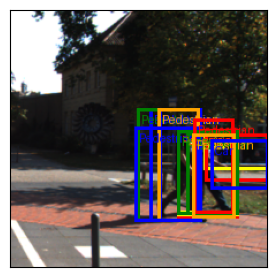

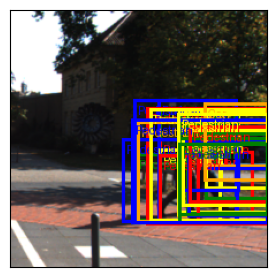

---------------------------------------------------------------------------------
(tensor([[[[255., 255., 255.,  ...,  47.,  63.,  84.],
          [255., 255., 255.,  ...,  31.,  46.,  55.],
          [255., 255., 255.,  ...,  36.,  36.,  36.],
          ...,
          [135., 131., 130.,  ..., 138., 135., 135.],
          [137., 131., 132.,  ..., 146., 136., 137.],
          [125., 124., 131.,  ..., 140., 132., 129.]],

         [[255., 255., 255.,  ...,  54.,  74.,  98.],
          [255., 255., 255.,  ...,  45.,  70.,  88.],
          [255., 255., 255.,  ...,  36.,  45.,  55.],
          ...,
          [129., 128., 127.,  ..., 136., 135., 136.],
          [128., 129., 128.,  ..., 137., 134., 134.],
          [125., 124., 126.,  ..., 133., 132., 134.]],

         [[255., 255., 255.,  ...,  45.,  36.,  50.],
          [255., 255., 255.,  ...,  30.,  46.,  38.],
          [255., 255., 255.,  ...,  26.,  25.,  29.],
          ...,
          [120., 124., 123.,  ..., 137., 137., 136.],
    

In [23]:
model = FastRCNN()
train_loader = data_loader
valid_loader = data_loader
batch_size = 1
loss_fn = MultiTaskLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # learnin rate and momentum could be changed.
epochs = 1
device = None



train_model(model, train_loader, valid_loader, batch_size, loss_fn, optimizer, epochs)

In [ ]:
# TODO 
# DONE - convert the image to 224 * 224
# DONE - Filter pictures that does not have object on it after transformations
# DONE - Maybe it needs to be converted to float??

# It is possible that there wont be 64 adequate proposals
# Sometimes kernel dies? 
# Is loss well calculated
# For Loss classificatoin weight is needed
# Validation is needed

